# INRIX Traffic Speed Data - Exploratory Data Analysis

This notebook performs exploratory data analysis on a large INRIX traffic speed CSV file. Due to the file's size, we'll first split it into smaller, more manageable chunks (< 100MB each) and then analyze the data to understand its characteristics and patterns.

## Workflow
1. Split the large CSV file into smaller chunks
2. Analyze data structure and statistics
3. Explore temporal patterns
4. Analyze speed distributions
5. Identify correlations and relationships

## 1. Import Required Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from pathlib import Path
import math
import time
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime

# Set plotting styles
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Display all columns
pd.set_option('display.max_columns', None)

## 2. File Path and Settings

In [4]:
# Define file paths
inrix_file_name = "SR60-1year"
data_dir = Path(f'../database/inrix-traffic-speed/{inrix_file_name}')
large_file_path = data_dir / f"{inrix_file_name}.csv"

# Define the directory for saving chunks
chunks_dir = data_dir / "chunks"
os.makedirs(chunks_dir, exist_ok=True) # Create directory if it doesn't exist

# Define the target size for each chunk (in MB)
target_chunk_size_mb = 100  # ~100MB

## 3. Check File Size and Structure

In [5]:
# Check file size in MB
if large_file_path.exists():
    file_size_mb = os.path.getsize(large_file_path) / (1024 * 1024)
    print(f"File size: {file_size_mb:.2f} MB")
    
    # Estimate the number of chunks needed
    num_chunks = math.ceil(file_size_mb / target_chunk_size_mb)
    print(f"Estimated number of chunks needed: {num_chunks}")
else:
    print(f"File {large_file_path} does not exist!")

# Preview the first few rows to understand the structure
try:
    df_sample = pd.read_csv(large_file_path, nrows=5)
    print("\nSample of the dataset (first 5 rows):")
    display(df_sample)
    
    # Get column information
    print("\nColumns in the dataset:")
    for col in df_sample.columns:
        print(f"- {col} (type: {df_sample[col].dtype})")
        
except Exception as e:
    print(f"Error reading file: {e}")

File size: 3020.90 MB
Estimated number of chunks needed: 31

Sample of the dataset (first 5 rows):


,tmc_code,measurement_tstamp,speed,historical_average_speed,reference_speed,travel_time_seconds,confidence_score,cvalue,Inrix 2013,Inrix 2019
0,115+04387,2024-09-24 00:00:00,51.0,49.0,49.0,10.98,30.0,100.0,2,6
1,115+04387,2024-09-24 00:01:00,52.0,49.0,49.0,10.77,30.0,100.0,2,6
2,115+04387,2024-09-24 00:02:00,51.0,49.0,49.0,10.98,30.0,100.0,2,6
3,115+04387,2024-09-24 00:03:00,51.0,49.0,49.0,10.98,30.0,100.0,2,6
4,115+04387,2024-09-24 00:04:00,51.0,49.0,49.0,10.98,30.0,100.0,2,6



Columns in the dataset:
- tmc_code (type: object)
- measurement_tstamp (type: object)
- speed (type: float64)
- historical_average_speed (type: float64)
- reference_speed (type: float64)
- travel_time_seconds (type: float64)
- confidence_score (type: float64)
- cvalue (type: float64)
- Inrix 2013 (type: int64)
- Inrix 2019 (type: int64)


## 4. Split the File into Smaller Chunks

In [10]:
def split_csv_file(file_path, output_dir, target_chunk_size_mb=95, chunksize=10000):
    """
    Split a large CSV file into smaller chunks
    
    Parameters:
    -----------
    file_path : str or Path
        Path to the large CSV file
    output_dir : str or Path
        Directory to save the chunks
    target_chunk_size_mb : float
        Target size for each chunk in MB
    chunksize : int
        Number of rows to read at once
        
    Returns:
    --------
    list
        List of paths to the created chunk files
    """
    start_time = time.time()
    chunk_files = []
    
    # Convert paths to strings for pandas
    file_path_str = str(file_path)
    output_dir_str = str(output_dir)
    
    # Get the base filename without extension
    base_filename = os.path.splitext(os.path.basename(file_path_str))[0]
    
    # Read the CSV in chunks
    reader = pd.read_csv(file_path_str, chunksize=chunksize)
    
    # Initialize variables for tracking
    chunk_idx = 1
    current_chunk_size = 0
    current_chunk_rows = []
    
    # Get total rows (approximate)
    if os.path.exists(file_path_str):
        # Count lines quickly
        with open(file_path_str, 'r') as f:
            total_rows = sum(1 for _ in f) - 1  # Subtract header
        print(f"Processing file with {total_rows} rows")
    else:
        total_rows = 0
    
    # Process each chunk
    rows_processed = 0
    for i, chunk in enumerate(reader):
        # Add the current chunk rows
        current_chunk_rows.append(chunk)
        
        # Track progress
        rows_processed += len(chunk)
        if (i + 1) % 10 == 0:  # Print status every 10 chunks
            percent_done = (rows_processed / total_rows) * 100 if total_rows > 0 else 0
            print(f"Processed {rows_processed} rows ({percent_done:.1f}%)")
        
        # Calculate the size of the current chunk in memory
        chunk_size_mb = sum(chunk.memory_usage(deep=True)) / (1024 * 1024)
        current_chunk_size += chunk_size_mb
        
        # Apply a correction factor to better match target file size
        # Memory size vs file size ratio is typically around 2.5-3x
        adjusted_size = current_chunk_size * 0.4  # Adjust this factor based on testing
        
        # If we've reached the target size or it's the last chunk
        if adjusted_size >= target_chunk_size_mb:
            # Combine all accumulated chunks
            combined_chunk = pd.concat(current_chunk_rows, ignore_index=True)
            
            # Save the combined chunk
            chunk_filename = f"{base_filename}_chunk_{chunk_idx:03d}.csv"
            chunk_path = os.path.join(output_dir_str, chunk_filename)
            combined_chunk.to_csv(chunk_path, index=False)
            
            # Add to list of chunk files
            chunk_files.append(chunk_path)
            
            # Log information
            print(f"Saved chunk {chunk_idx}: {len(combined_chunk)} rows, {current_chunk_size:.2f} MB in memory")
            
            # Check actual file size
            actual_file_size_mb = os.path.getsize(chunk_path) / (1024 * 1024)
            print(f"  -> Actual file size: {actual_file_size_mb:.2f} MB")
            
            # Reset for the next chunk
            chunk_idx += 1
            current_chunk_size = 0
            current_chunk_rows = []
    
    # Save any remaining rows
    if current_chunk_rows:
        combined_chunk = pd.concat(current_chunk_rows, ignore_index=True)
        chunk_filename = f"{base_filename}_chunk_{chunk_idx:03d}.csv"
        chunk_path = os.path.join(output_dir_str, chunk_filename)
        combined_chunk.to_csv(chunk_path, index=False)
        chunk_files.append(chunk_path)
        
        print(f"Saved final chunk {chunk_idx}: {len(combined_chunk)} rows, {current_chunk_size:.2f} MB in memory")
        
        # Check actual file size
        actual_file_size_mb = os.path.getsize(chunk_path) / (1024 * 1024)
        print(f"  -> Actual file size: {actual_file_size_mb:.2f} MB")
    
    elapsed_time = time.time() - start_time
    print(f"\nFile splitting completed in {elapsed_time:.2f} seconds")
    print(f"Created {len(chunk_files)} chunk files")
    
    return chunk_files

In [11]:
# Execute the file splitting if the large file exists
if large_file_path.exists():
    print(f"Starting to split file: {large_file_path}")
    
    chunk_files = split_csv_file(
        large_file_path, 
        chunks_dir, 
        target_chunk_size_mb=target_chunk_size_mb,
        chunksize=50000  # Adjust this based on your memory capacity
    )
    
    # Display information about the created chunks
    print("\nCreated chunk files:")
    for i, chunk_file in enumerate(chunk_files):
        file_size_mb = os.path.getsize(chunk_file) / (1024 * 1024)
        print(f"{i+1}. {os.path.basename(chunk_file)}: {file_size_mb:.2f} MB")
else:
    print(f"File {large_file_path} does not exist. Cannot split the file.")

Starting to split file: ../database/inrix-traffic-speed/SR60-1year/SR60-1year.csv
Processing file with 43521980 rows
Processing file with 43521980 rows
Processed 500000 rows (1.1%)
Processed 500000 rows (1.1%)
Processed 1000000 rows (2.3%)
Processed 1000000 rows (2.3%)
Saved chunk 1: 1300000 rows, 255.40 MB in memory
  -> Actual file size: 86.35 MB
Processed 1500000 rows (3.4%)
Saved chunk 1: 1300000 rows, 255.40 MB in memory
  -> Actual file size: 86.35 MB
Processed 1500000 rows (3.4%)
Processed 2000000 rows (4.6%)
Processed 2000000 rows (4.6%)
Processed 2500000 rows (5.7%)
Processed 2500000 rows (5.7%)
Saved chunk 2: 1300000 rows, 255.40 MB in memory
  -> Actual file size: 86.15 MB
Saved chunk 2: 1300000 rows, 255.40 MB in memory
  -> Actual file size: 86.15 MB
Processed 3000000 rows (6.9%)
Processed 3000000 rows (6.9%)
Processed 3500000 rows (8.0%)
Processed 3500000 rows (8.0%)
Saved chunk 3: 1300000 rows, 255.40 MB in memory
  -> Actual file size: 86.29 MB
Processed 4000000 rows (9

## 5. Exploratory Data Analysis

Now that we've split the large CSV file into smaller, more manageable chunks, let's analyze the data to understand its characteristics. We'll work with one of the chunks for our initial analysis.

In [12]:
# Get the list of chunk files after splitting
chunk_files = sorted(glob.glob(str(chunks_dir / f"*_chunk_*.csv")))

# If no chunk files found (maybe we didn't run the splitting yet), list any CSV files
if not chunk_files:
    chunk_files = sorted(glob.glob(str(chunks_dir / "*.csv")))

# If we have at least one chunk file, load the first one for analysis
if chunk_files:
    print(f"Loading first chunk file: {os.path.basename(chunk_files[0])}")
    df = pd.read_csv(chunk_files[0])
    print(f"Loaded {len(df)} rows with {len(df.columns)} columns")
else:
    print("No chunk files found for analysis!")
    # Create a sample dataframe for demonstration if no files exist
    df = pd.DataFrame()

Loading first chunk file: SR60-1year_chunk_001.csv
Loaded 1300000 rows with 10 columns
Loaded 1300000 rows with 10 columns


### 5.1 Data Overview and Basic Statistics

In [13]:
# Check if we have data to analyze
if not df.empty:
    # Basic information about the dataframe
    print("Dataset shape:", df.shape)
    
    # Display the first few rows
    print("\nFirst 5 rows:")
    display(df.head())
    
    # Display column information
    print("\nColumn information:")
    display(df.info())
    
    # Summary statistics for numerical columns
    print("\nSummary statistics for numerical columns:")
    display(df.describe())
    
    # Check for missing values
    missing_values = df.isnull().sum()
    missing_pct = (missing_values / len(df)) * 100;
    
    # Display missing values if any
    if missing_values.sum() > 0:
        print("\nMissing values by column:")
        missing_df = pd.DataFrame({
            'Column': missing_values.index,
            'Missing Count': missing_values.values,
            'Missing %': missing_pct.values
        })
        display(missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False))
    else:
        print("\nNo missing values found!")
else:
    print("No data available for analysis.")

Dataset shape: (1300000, 10)

First 5 rows:


,tmc_code,measurement_tstamp,speed,historical_average_speed,reference_speed,travel_time_seconds,confidence_score,cvalue,Inrix 2013,Inrix 2019
0,115+04387,2024-09-24 00:00:00,51.0,49.0,49.0,10.98,30.0,100.0,2.0,6
1,115+04387,2024-09-24 00:01:00,52.0,49.0,49.0,10.77,30.0,100.0,2.0,6
2,115+04387,2024-09-24 00:02:00,51.0,49.0,49.0,10.98,30.0,100.0,2.0,6
3,115+04387,2024-09-24 00:03:00,51.0,49.0,49.0,10.98,30.0,100.0,2.0,6
4,115+04387,2024-09-24 00:04:00,51.0,49.0,49.0,10.98,30.0,100.0,2.0,6



Column information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300000 entries, 0 to 1299999
Data columns (total 10 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   tmc_code                  1300000 non-null  object 
 1   measurement_tstamp        1300000 non-null  object 
 2   speed                     1300000 non-null  float64
 3   historical_average_speed  1300000 non-null  float64
 4   reference_speed           1300000 non-null  float64
 5   travel_time_seconds       1300000 non-null  float64
 6   confidence_score          1300000 non-null  float64
 7   cvalue                    1298528 non-null  float64
 8   Inrix 2013                1253929 non-null  float64
 9   Inrix 2019                1300000 non-null  int64  
dtypes: float64(7), int64(1), object(2)
memory usage: 99.2+ MB


None


Summary statistics for numerical columns:


,speed,historical_average_speed,reference_speed,travel_time_seconds,confidence_score,cvalue,Inrix 2013,Inrix 2019
count,1.300000e+06,1.300000e+06,1.300000e+06,1.300000e+06,1.300000e+06,1.298528e+06,1.253929e+06,1.300000e+06
mean,6.519163e+01,6.523744e+01,6.630780e+01,2.895062e+01,2.998765e+01,9.977212e+01,6.341149e+01,4.132055e+01
std,1.067473e+01,1.156333e+01,1.026476e+01,2.224172e+01,4.686331e-01,1.599794e+00,4.766037e+01,2.769840e+01
min,4.000000e+00,1.100000e+01,2.500000e+01,1.630000e+00,1.000000e+01,3.100000e+01,0.000000e+00,1.000000e+00
25%,6.600000e+01,6.700000e+01,6.900000e+01,1.463000e+01,3.000000e+01,1.000000e+02,1.500000e+01,1.500000e+01
50%,6.900000e+01,6.900000e+01,7.000000e+01,2.839000e+01,3.000000e+01,1.000000e+02,6.100000e+01,4.000000e+01
75%,7.100000e+01,7.100000e+01,7.100000e+01,3.680000e+01,3.000000e+01,1.000000e+02,1.010000e+02,6.100000e+01
max,7.800000e+01,7.700000e+01,7.300000e+01,5.953000e+02,3.000000e+01,1.000000e+02,2.340000e+02,1.550000e+02



Missing values by column:


,Column,Missing Count,Missing %
8,Inrix 2013,46071,3.543923
7,cvalue,1472,0.113231


### 5.2 Data Type Handling and Preprocessing

Let's handle data types and preprocessing. If the dataset contains timestamp columns, we'll convert them to the appropriate format.

### 5.3 Speed Distribution Analysis

Let's analyze the distribution of traffic speeds, which is likely a key variable in the dataset.

Potential speed columns found: ['speed', 'historical_average_speed', 'reference_speed']


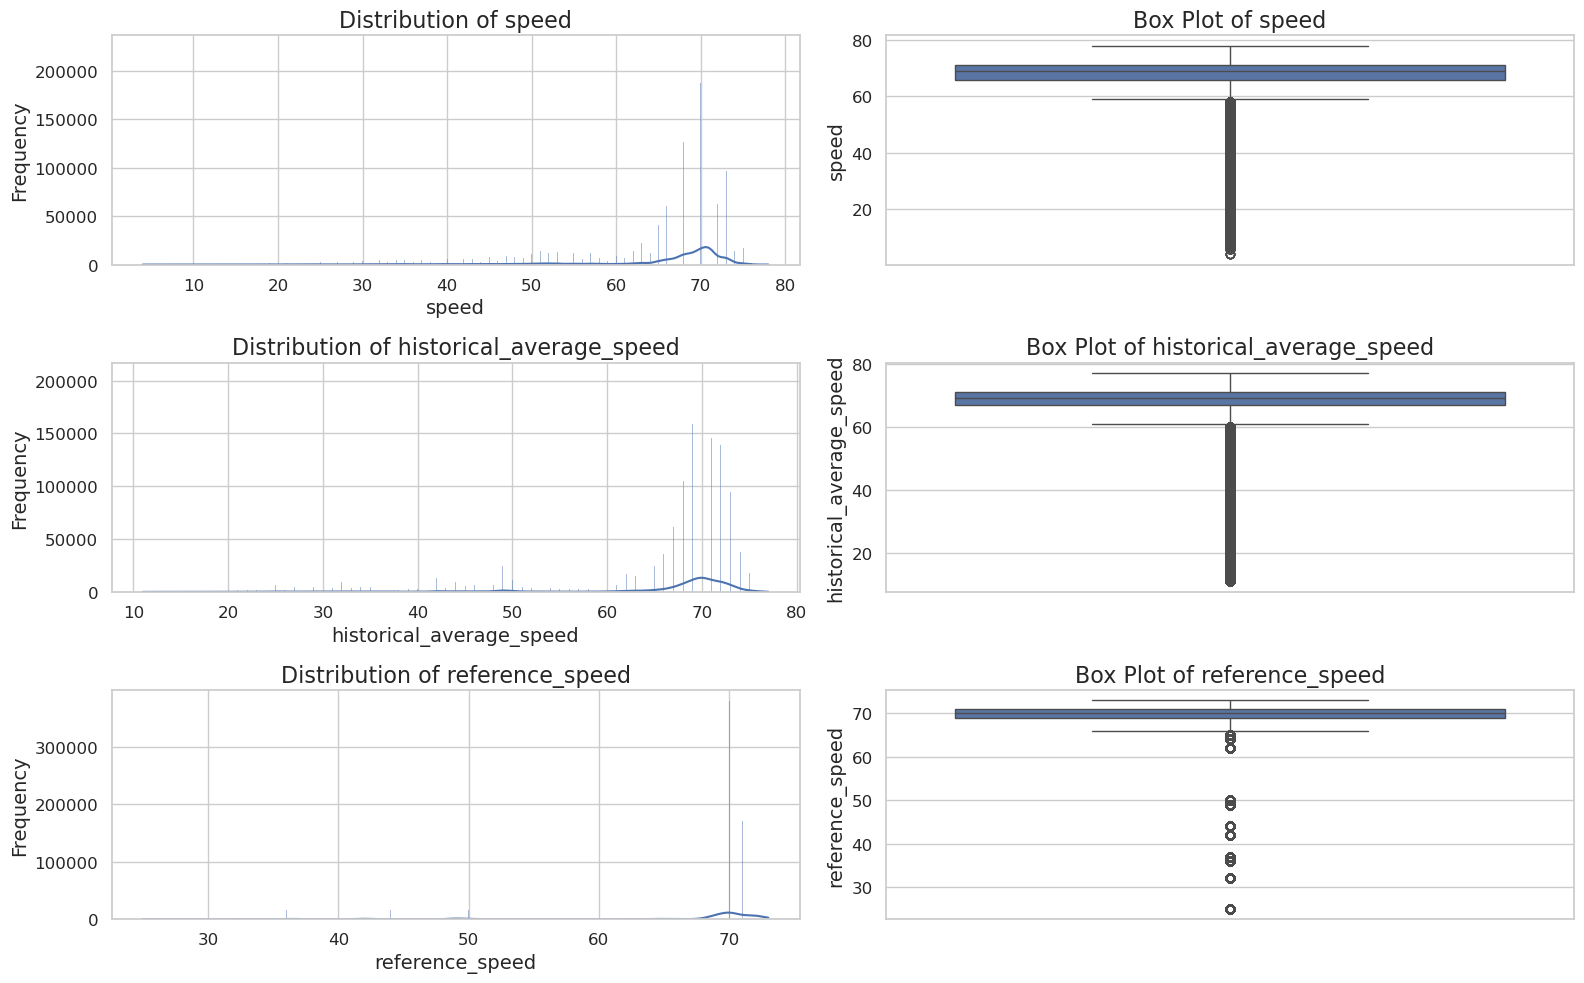


Statistics for speed:
Mean: 65.19
Median: 69.00
Min: 4.00
Max: 78.00
Standard Deviation: 10.67
5th percentile: 40.00
95th percentile: 73.00

Statistics for historical_average_speed:
Mean: 65.24
Median: 69.00
Min: 11.00
Max: 77.00
Standard Deviation: 11.56
5th percentile: 36.00
95th percentile: 73.00

Statistics for reference_speed:
Mean: 66.31
Median: 70.00
Min: 25.00
Max: 73.00
Standard Deviation: 10.26
5th percentile: 42.00
95th percentile: 72.00
95th percentile: 72.00


In [14]:
if not df.empty:
    # Find speed-related columns
    speed_columns = ["speed", "historical_average_speed", "reference_speed"]
    
    print(f"Potential speed columns found: {speed_columns}")
    
    # If we found speed columns, analyze them
    if speed_columns:
        # Create histograms for each speed column
        plt.figure(figsize=(16, 10))
        
        for i, col in enumerate(speed_columns):
            plt.subplot(len(speed_columns), 2, 2*i+1)
            
            # Ensure the column has numerical data
            if pd.api.types.is_numeric_dtype(df[col]):
                # Histogram
                sns.histplot(df[col].dropna(), kde=True)
                plt.title(f"Distribution of {col}")
                plt.xlabel(col)
                plt.ylabel("Frequency")
                
                # Box plot
                plt.subplot(len(speed_columns), 2, 2*i+2)
                sns.boxplot(y=df[col].dropna())
                plt.title(f"Box Plot of {col}")
                plt.ylabel(col)
            else:
                plt.text(0.5, 0.5, f"{col} is not numeric", 
                         ha='center', va='center', transform=plt.gca().transAxes)
        
        plt.tight_layout()
        plt.show()
        
        # Calculate basic statistics for speed columns
        for col in speed_columns:
            if pd.api.types.is_numeric_dtype(df[col]):
                print(f"\nStatistics for {col}:")
                stats = df[col].describe()
                print(f"Mean: {stats['mean']:.2f}")
                print(f"Median: {df[col].median():.2f}")
                print(f"Min: {stats['min']:.2f}")
                print(f"Max: {stats['max']:.2f}")
                print(f"Standard Deviation: {stats['std']:.2f}")
                
                # Calculate percentiles
                print(f"5th percentile: {df[col].quantile(0.05):.2f}")
                print(f"95th percentile: {df[col].quantile(0.95):.2f}")
    else:
        print("No speed-related columns found in the dataset.")
else:
    print("No data available for speed distribution analysis.")

### 5.4 Temporal Analysis

If our dataset contains timestamp information, let's analyze how traffic patterns change over time.

In [17]:
df["measurement_tstamp"] = pd.to_datetime(df["measurement_tstamp"])

Found datetime columns: ['measurement_tstamp']
Using measurement_tstamp for temporal analysis
Using speed for speed metrics
Using speed for speed metrics


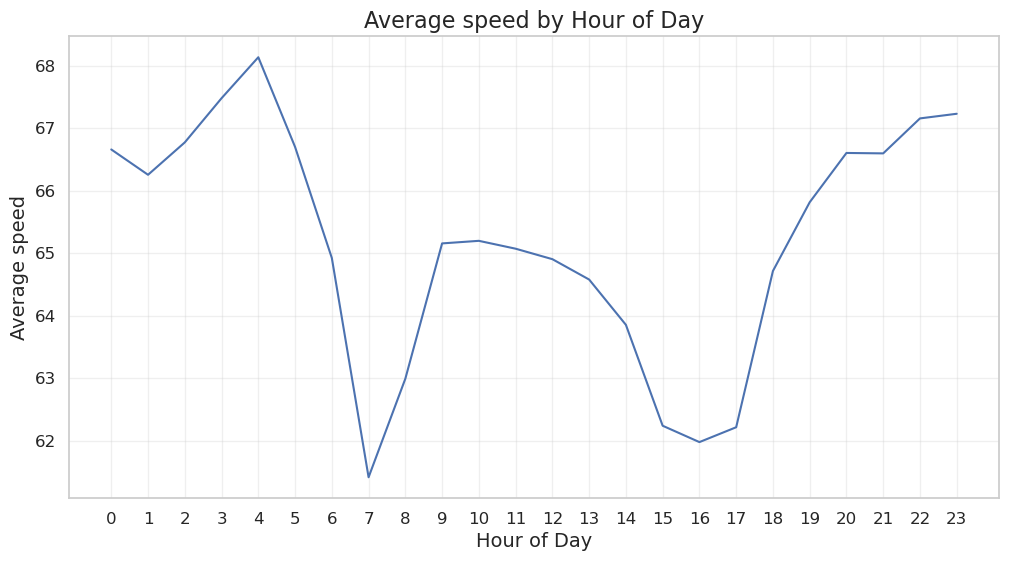

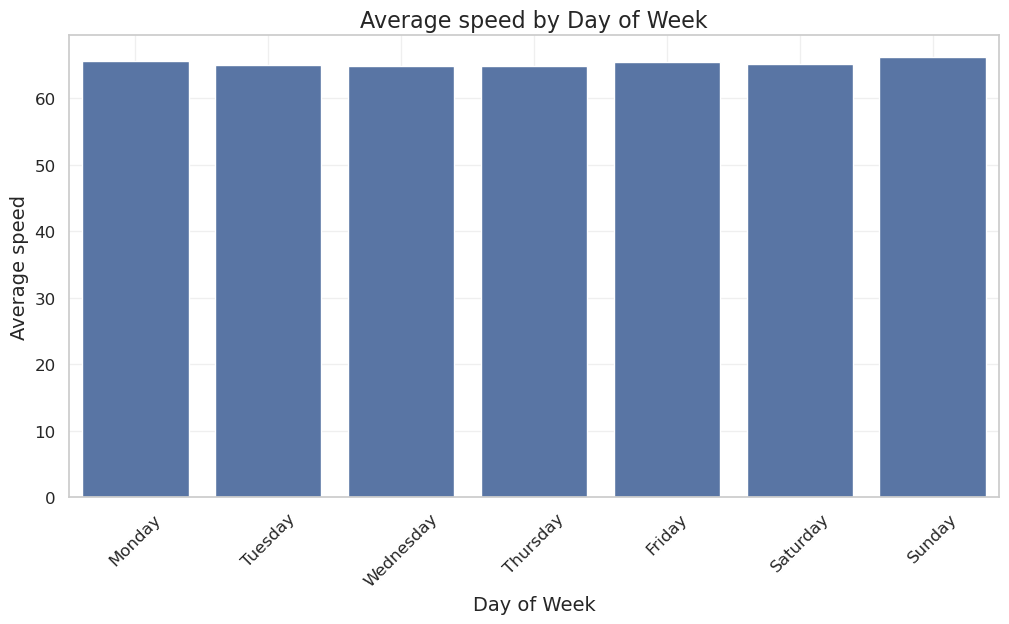

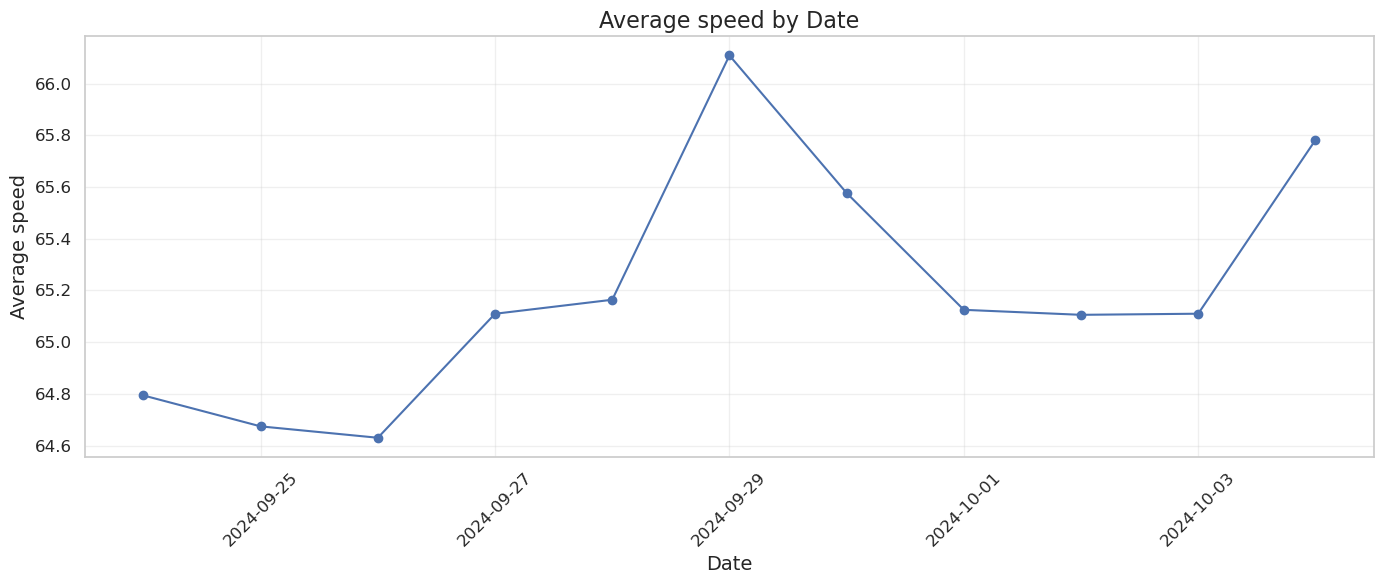

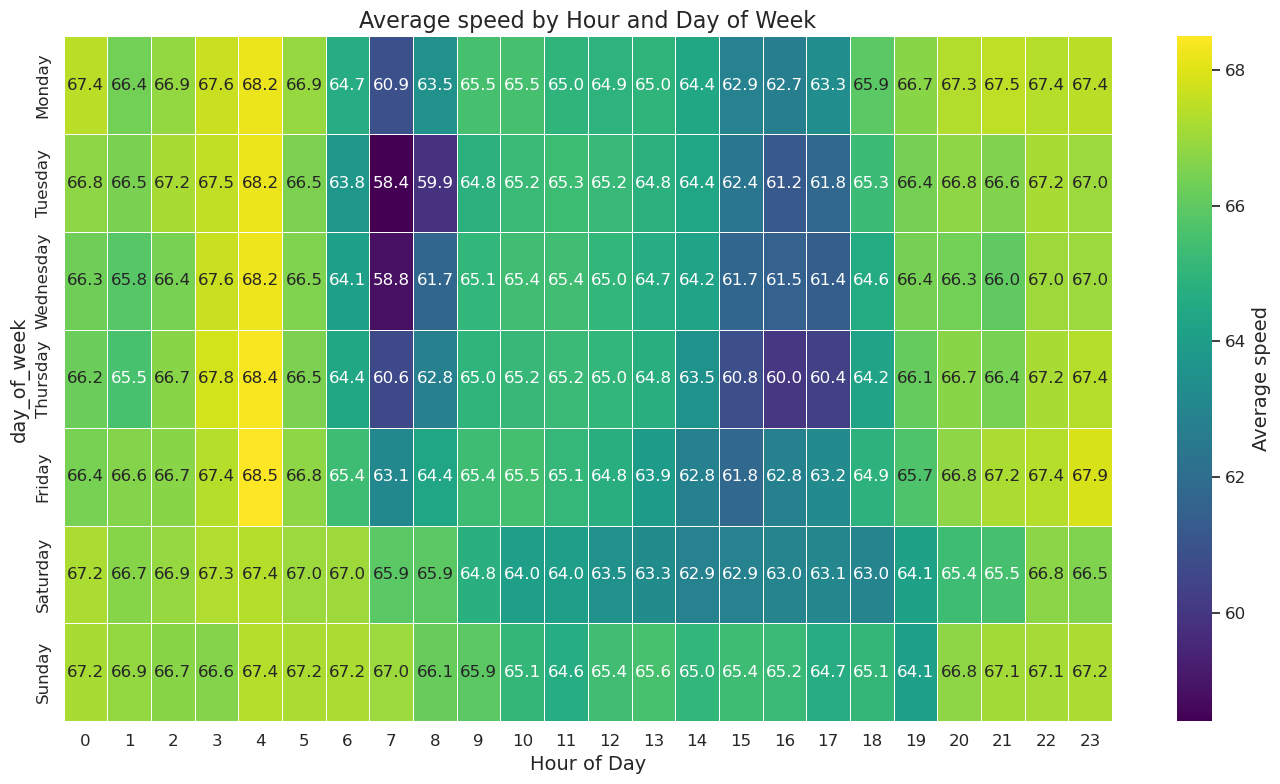

In [18]:
if not df.empty:
    # Check if we have datetime columns
    datetime_cols = df.select_dtypes(include=['datetime64']).columns.tolist()
    
    if datetime_cols:
        print(f"Found datetime columns: {datetime_cols}")
        
        # Use the first datetime column for analysis
        time_col = datetime_cols[0]
        print(f"Using {time_col} for temporal analysis")
        
        # Extract time components
        df['hour'] = df[time_col].dt.hour
        df['day_of_week'] = df[time_col].dt.day_name()
        df['date'] = df[time_col].dt.date
        
        # Find a likely speed column for analysis
        speed_cols = [col for col in df.columns if any(speed_str in col.lower() for speed_str in 
                                                      ['speed', 'mph', 'kph', 'velocity'])]
        
        if speed_cols:
            speed_col = speed_cols[0]  # Use the first identified speed column
            print(f"Using {speed_col} for speed metrics")
            
            # Ensure the column is numeric
            if pd.api.types.is_numeric_dtype(df[speed_col]):
                # 1. Average speed by hour of day
                plt.figure(figsize=(12, 6))
                hourly_speed = df.groupby('hour')[speed_col].mean()
                sns.lineplot(x=hourly_speed.index, y=hourly_speed.values)
                plt.title(f"Average {speed_col} by Hour of Day")
                plt.xlabel("Hour of Day")
                plt.ylabel(f"Average {speed_col}")
                plt.xticks(range(0, 24))
                plt.grid(True, alpha=0.3)
                plt.show()
                
                # 2. Average speed by day of week
                plt.figure(figsize=(12, 6))
                # Ensure proper day order
                day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
                daily_speed = df.groupby('day_of_week')[speed_col].mean().reindex(day_order)
                sns.barplot(x=daily_speed.index, y=daily_speed.values)
                plt.title(f"Average {speed_col} by Day of Week")
                plt.xlabel("Day of Week")
                plt.ylabel(f"Average {speed_col}")
                plt.xticks(rotation=45)
                plt.grid(True, alpha=0.3)
                plt.show()
                
                # 3. Speed by date (if multiple dates available)
                if df['date'].nunique() > 1:
                    plt.figure(figsize=(14, 6))
                    date_speed = df.groupby('date')[speed_col].mean()
                    plt.plot(date_speed.index, date_speed.values, marker='o')
                    plt.title(f"Average {speed_col} by Date")
                    plt.xlabel("Date")
                    plt.ylabel(f"Average {speed_col}")
                    plt.grid(True, alpha=0.3)
                    plt.xticks(rotation=45)
                    plt.tight_layout()
                    plt.show()
                
                # 4. Heatmap of hour vs day of week
                if df['date'].nunique() > 1:
                    plt.figure(figsize=(14, 8))
                    # Create pivot table
                    hour_day_pivot = df.pivot_table(
                        index='day_of_week', 
                        columns='hour',
                        values=speed_col,
                        aggfunc='mean'
                    ).reindex(day_order)  # Ensure proper day order
                    
                    # Create heatmap
                    sns.heatmap(
                        hour_day_pivot,
                        cmap='viridis',
                        annot=True,
                        fmt=".1f",
                        linewidths=.5,
                        cbar_kws={'label': f'Average {speed_col}'}
                    )
                    plt.title(f"Average {speed_col} by Hour and Day of Week")
                    plt.xlabel("Hour of Day")
                    plt.tight_layout()
                    plt.show()
            else:
                print(f"Column {speed_col} is not numeric. Cannot perform speed analysis.")
        else:
            print("No speed-related columns found for temporal analysis.")
    else:
        print("No datetime columns found for temporal analysis. Consider converting time-related columns to datetime format.")
else:
    print("No data available for temporal analysis.")

### 5.5 Spatial Analysis

If our dataset contains geographic coordinates, let's visualize the traffic data on a map to identify spatial patterns.

In [ ]:
if not df.empty:
    # Look for latitude and longitude columns
    lat_cols = [col for col in df.columns if any(lat_str in col.lower() for lat_str in 
                                               ['lat', 'latitude', 'y_coord'])]
    lon_cols = [col for col in df.columns if any(lon_str in col.lower() for lon_str in 
                                               ['lon', 'long', 'longitude', 'x_coord'])]
    
    if lat_cols and lon_cols:
        lat_col = lat_cols[0]  # Use the first identified latitude column
        lon_col = lon_cols[0]  # Use the first identified longitude column
        
        print(f"Found coordinate columns: {lat_col} and {lon_col}")
        
        # Check if these columns are numeric
        if (pd.api.types.is_numeric_dtype(df[lat_col]) and 
            pd.api.types.is_numeric_dtype(df[lon_col])):
            
            # Get a sample if there are too many points
            sample_size = min(10000, len(df))
            if len(df) > sample_size:
                df_sample = df.sample(sample_size, random_state=42)
                print(f"Using a sample of {sample_size} points for mapping")
            else:
                df_sample = df
                
            # Find a likely speed column for analysis
            speed_cols = [col for col in df.columns if any(speed_str in col.lower() for speed_str in 
                                                         ['speed', 'mph', 'kph', 'velocity'])]
            
            if speed_cols:
                speed_col = speed_cols[0]  # Use the first identified speed column
                print(f"Using {speed_col} for speed coloring")
                
                # Create a map using plotly
                fig = px.scatter_mapbox(
                    df_sample,
                    lat=lat_col, 
                    lon=lon_col,
                    color=speed_col if pd.api.types.is_numeric_dtype(df[speed_col]) else None,
                    size_max=10,
                    zoom=10,
                    mapbox_style="open-street-map",
                    height=800,
                    width=1200,
                    title=f"Traffic Speed Map (Sample of {sample_size} points)"
                )
                
                fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})
                fig.show()
            else:
                # Basic map without speed coloring
                fig = px.scatter_mapbox(
                    df_sample,
                    lat=lat_col, 
                    lon=lon_col,
                    zoom=10,
                    mapbox_style="open-street-map",
                    height=800,
                    width=1200,
                    title=f"Traffic Data Map (Sample of {sample_size} points)"
                )
                
                fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})
                fig.show()
            
            # Display coordinate ranges
            print(f"\nLatitude range: {df[lat_col].min():.6f} to {df[lat_col].max():.6f}")
            print(f"Longitude range: {df[lon_col].min():.6f} to {df[lon_col].max():.6f}")
            
            # Try to identify location clusters
            if len(df) > 1000:
                print("\nCalculating point density to identify major areas...")
                
                # Create a 2D histogram to find high-density areas
                lat_bins = 20
                lon_bins = 20
                
                plt.figure(figsize=(12, 10))
                plt.hist2d(df[lon_col], df[lat_col], bins=(lon_bins, lat_bins), cmap='viridis')
                plt.colorbar(label='Point Count')
                plt.title('Traffic Data Point Density')
                plt.xlabel('Longitude')
                plt.ylabel('Latitude')
                plt.tight_layout()
                plt.show()
        else:
            print(f"Columns {lat_col} and/or {lon_col} are not numeric. Cannot create map.")
    else:
        print("No latitude/longitude columns found for spatial analysis.")
else:
    print("No data available for spatial analysis.")

### 5.6 Correlation Analysis

Let's look at the relationships between different variables in our dataset.